# Notes

## About
This program runs several rounds of Federated Learning, where each round is composed a number of "t" iterations, in order to plot some graphics and statistics.

## Considerations
In Choi's article, after formula 14, the author says that μ1 is the step
size, and then he states that μ1 = 0.01. In practice, μ1 is used in SGD,
and thus it cannot be the step size but, the learning rate.

Learning rate is a hyperparameter that controls how much the weights of 
a neural network are updated during training. A larger learning rate 
will cause the weights to be updated more quickly, while a smaller 
learning rate will cause the weights to be updated more slowly.

Step size is the amount that the weights of a neural network are updated
in each iteration of training. The step size is determined by the 
learning rate.

In other words, the learning rate is a global setting that determines 
how quickly the weights of a neural network are updated, while the 
step size is a local setting that determines how much the weights are 
updated in each iteration.
A good learning rate will allow the neural network to converge to a good
solution without overfitting the training data. A too large learning 
rate will cause the neural network to diverge, while a too small 
learning rate will cause the neural network to converge slowly.
The step size is typically set to be a fraction of the learning rate. 
For example, if the learning rate is 0.01, then the step size might be 
set to 0.001. This ensures that the weights are updated in a controlled 
manner and that the neural network does not diverge. The cases where the
learning rate is smaller than the step size are:

When the neural network is initialized with very large weights: When the
weights of a neural network are initialized with very large values, 
the step size may need to be larger than the learning rate in order to 
prevent the neural network from diverging. This is because the gradient 
of the loss function will be very large for large weights, and a small 
step size will not be enough to move the weights in the correct direction.

When the neural network is trained on a very noisy dataset: When the 
neural network is trained on a very noisy dataset, the step size may 
need to be larger than the learning rate in order to prevent the neural 
network from getting stuck in a local minimum. This is because the 
gradient of the loss function will be very noisy for noisy data, and a 
small step size will not be able to escape from local minima.

When the neural network is using a momentum optimizer: Momentum 
optimizers are a type of gradient descent optimizer that uses the 
previous gradients to estimate the next gradient. This can be helpful 
for training neural networks with large step sizes, as it can help to 
prevent the neural network from diverging. However, it can also lead to 
the step size being greater than the learning rate, especially if the 
momentum is too high.

## Implementation notes
From the point of view of a practical hierarchical clustering implementation, all devices should calculate their weights, upload them to the clusterhead (which will act as a "mini Base Station (BS)", aggregating the information) and finally, the clusterhead tries to upload its processed cluster data to the basestation, which may or may not succeed.

In order to save processing and time in this simulation, it will only calculate the aggregation information if, and only if, the clusterhead can successfully send its data to the BS.

## Pooling vs Polling observation
- Pooling is the process of combining the local model updates from all client devices into a single, global model update. This update is then sent back to the client devices, which use it to improve their local models.
- Polling is the process of regularly checking the status of a task or process. In federated learning, polling can be used to check if the client devices have finished training their local models and are ready to send their updates to the central server. However, polling is not a necessary part of federated learning. The central server can also use a push mechanism to send updates to the client devices when they are ready.


# Labraries importings

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import logging
import pathlib

import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import seaborn as sns

# Depending on where this notebook is run, such as Google Colab or locally,
# it may need to switch the way that tqdm is imported.
from logging.handlers import RotatingFileHandler
from tqdm import tqdm
# from tqdm.notebook import tqdm # Use this import if running on Colab.

from Clustering.proposed_clustering_algorithm import devices_generator, devices_clusterizer
from Models.models_arrangement import error_calculator

# Variable definitions

## System model

In [3]:
BS_RADIUS = 300 # Value in meters. BS = BaseStation. In document: R_(BS).
DEVICE_RADIUS = 15 # Value in meters. Considering Bluetooth low energy. In document: R_(D2D).
MOBILE_DEVICES = 1000 # In document: K.

## FL schema

In [4]:
FL_ROUNDS = 1000 # FL = Federated Learning
DATA_DIMENSION = 10 # In document: L.
LEARNING_RATE = 0.01
STEP_SIZE = 0.1 # In document: 𝜇.

LIST_OF_FL_ITERATIONS_PER_ROUND = [1, 200] # Using [1, 200], the plot will start at 1 and will finish at 200 steps. In document: t.

## ALOHA protocol

In [5]:
PARALLEL_CHANNELS = 10 # In document: M.
PROB_TO_COMPUTE_THE_LOCAL_UPDATE = 0.1 # Used for both users and CHs. In document: P_comp.

## Clustering algorithm

In [6]:
# For a better clustering, the "MAX_DEVICES_PER_CLUSTER" number should be 
# even and higher than 3, but using other values will not cause any problems.
MAX_DEVICES_PER_CLUSTER = 10 # In document: C_max.
BALACING_CLUSTER_PARAM = 4 # In document: 𝛽.

# Working directory

## Experimental runs folder

In [7]:
folder_name = f'Runs/{MOBILE_DEVICES} devices'
pathlib.Path(folder_name).mkdir(parents=True, exist_ok=True) 

## Logs handler

In [8]:
log_filename = f'{folder_name}/results.log'
handler = [RotatingFileHandler(log_filename, maxBytes=10485760, backupCount=5)] # 10485760 bytes = 10 Mbytes
logging.basicConfig(handlers=handler,
                    level=logging.INFO,
                    format="{message}", 
                    style='{',
                    datefmt="%d/%m/%Y %H:%M:%S")
# The below code is done so that the message logged is also displayed on the console.
logger = logging.getLogger('results')
logger.setLevel(logging.INFO)

# Defines a Handler which writes INFO messages or higher to the sys.stderr.
console = logging.StreamHandler()
console.setLevel(logging.INFO)
# Sets a format that is simpler for console display.
formatter = logging.Formatter('{message}',
                                style='{')
# Tell the handler to use this format.
console.setFormatter(formatter)
logger.addHandler(console)

# Results

## Running the calculations

In [9]:
%%time

clustered_devices_rate_list = list()

#######################################################################################################
error_norm_1_list = list()
error_norm_2_list = list()
error_norm_3_list = list()

error_norm_1_d2d_list = list()
error_norm_2_d2d_list = list()
error_norm_3_d2d_list = list()

#######################################################################################################
model_1_uploads_list = list()
model_1_d2d_uploads_list = list()
model_1_d2d_clusterheads_uploads_list = list()

model_2_uploads_list = list()
model_2_d2d_uploads_list = list()
model_2_d2d_clusterheads_uploads_list = list()

model_3_uploads_list = list()
model_3_d2d_uploads_list = list()
model_3_d2d_clusterheads_uploads_list = list()

#######################################################################################################
for iteration_t in LIST_OF_FL_ITERATIONS_PER_ROUND:
    print(f'Value of Iteration_t: {iteration_t}')
    FL_clustered_devices_rate_list = list()
    
    ###################################################################################################
    min_errors_of_the_FL_round_model_1_list = list()
    min_errors_of_the_FL_round_model_2_list = list()
    min_errors_of_the_FL_round_model_3_list = list()
    min_errors_of_the_FL_round_model_1_d2d_list = list()
    min_errors_of_the_FL_round_model_2_d2d_list = list()
    min_errors_of_the_FL_round_model_3_d2d_list = list()

    ###################################################################################################
    model_1_total_of_successful_uploads_list = list()
    model_2_total_of_successful_uploads_list = list()
    model_3_total_of_successful_uploads_list = list()
    model_1_d2d_total_of_successful_uploads_list = list()
    model_2_d2d_total_of_successful_uploads_list = list()
    model_3_d2d_total_of_successful_uploads_list = list()
    model_1_d2d_total_of_successful_clusterheads_uploads_list = list()
    model_2_d2d_total_of_successful_clusterheads_uploads_list = list()
    model_3_d2d_total_of_successful_clusterheads_uploads_list = list()

    ###################################################################################################
    for FL_round in tqdm(range(FL_ROUNDS) if iteration_t != 1 else range(1)):
        devices_with_information_dict, _ = devices_generator(number_of_devices=MOBILE_DEVICES, 
                                                             bs_radius=BS_RADIUS)
        generated_clusters = devices_clusterizer(device_radius=DEVICE_RADIUS, 
                                                 max_devices_per_cluster=MAX_DEVICES_PER_CLUSTER, 
                                                 min_devices_per_cluster=BALACING_CLUSTER_PARAM, 
                                                 devices_information_dict=devices_with_information_dict)
        clustered_devices_rate, \
        error_norm_of_model_1, \
        error_norm_of_model_2, \
        error_norm_of_model_3, \
        error_norm_of_model_1_d2d, \
        error_norm_of_model_2_d2d, \
        error_norm_of_model_3_d2d, \
        model_1_total_of_successful_uploads, \
        model_2_total_of_successful_uploads, \
        model_3_total_of_successful_uploads, \
        model_1_d2d_total_of_successful_uploads, \
        model_2_d2d_total_of_successful_uploads, \
        model_3_d2d_total_of_successful_uploads, \
        model_1_d2d_total_of_successful_clusterheads_uploads, \
        model_2_d2d_total_of_successful_clusterheads_uploads, \
        model_3_d2d_total_of_successful_clusterheads_uploads = error_calculator(
                                        number_of_mobile_devices__k=MOBILE_DEVICES,
                                        data_dimension__L=DATA_DIMENSION,
                                        number_of_parallel_channels__M=PARALLEL_CHANNELS,
                                        probability_that_user_can_compute_its_local_update__pcomp=PROB_TO_COMPUTE_THE_LOCAL_UPDATE,
                                        number_of_iterations__t=iteration_t,
                                        learning_rate__u1=LEARNING_RATE,
                                        step_size__u=STEP_SIZE,
                                        clusters_list=nb.typed.List(generated_clusters))
        FL_clustered_devices_rate_list.append(clustered_devices_rate)

        min_errors_of_the_FL_round_model_1_list.append(error_norm_of_model_1)
        min_errors_of_the_FL_round_model_2_list.append(error_norm_of_model_2)
        min_errors_of_the_FL_round_model_3_list.append(error_norm_of_model_3)
        min_errors_of_the_FL_round_model_1_d2d_list.append(error_norm_of_model_1_d2d)
        min_errors_of_the_FL_round_model_2_d2d_list.append(error_norm_of_model_2_d2d)
        min_errors_of_the_FL_round_model_3_d2d_list.append(error_norm_of_model_3_d2d)
        
        ###############################################################################################
        model_1_total_of_successful_uploads_list.append(model_1_total_of_successful_uploads)
        model_2_total_of_successful_uploads_list.append(model_2_total_of_successful_uploads)
        model_3_total_of_successful_uploads_list.append(model_3_total_of_successful_uploads)
        model_1_d2d_total_of_successful_uploads_list.append(model_1_d2d_total_of_successful_uploads)
        model_2_d2d_total_of_successful_uploads_list.append(model_2_d2d_total_of_successful_uploads)
        model_3_d2d_total_of_successful_uploads_list.append(model_3_d2d_total_of_successful_uploads)
        model_1_d2d_total_of_successful_clusterheads_uploads_list.append(model_1_d2d_total_of_successful_clusterheads_uploads)
        model_2_d2d_total_of_successful_clusterheads_uploads_list.append(model_2_d2d_total_of_successful_clusterheads_uploads)
        model_3_d2d_total_of_successful_clusterheads_uploads_list.append(model_3_d2d_total_of_successful_clusterheads_uploads)

    ###################################################################################################
    clustered_devices_rate_list_mean = np.mean(FL_clustered_devices_rate_list)
    clustered_devices_rate_list.append(round(clustered_devices_rate_list_mean, 3))

    ###################################################################################################
    model_1_mean_of_the_FL_rounds = np.mean(min_errors_of_the_FL_round_model_1_list)
    model_2_mean_of_the_FL_rounds = np.mean(min_errors_of_the_FL_round_model_2_list)
    model_3_mean_of_the_FL_rounds = np.mean(min_errors_of_the_FL_round_model_3_list)

    model_1_d2d_mean_of_the_FL_rounds = np.mean(min_errors_of_the_FL_round_model_1_d2d_list)
    model_2_d2d_mean_of_the_FL_rounds = np.mean(min_errors_of_the_FL_round_model_2_d2d_list)
    model_3_d2d_mean_of_the_FL_rounds = np.mean(min_errors_of_the_FL_round_model_3_d2d_list)

    ###################################################################################################
    error_norm_1_list.append(model_1_mean_of_the_FL_rounds)
    error_norm_2_list.append(model_2_mean_of_the_FL_rounds)
    error_norm_3_list.append(model_3_mean_of_the_FL_rounds)

    error_norm_1_d2d_list.append(model_1_d2d_mean_of_the_FL_rounds)
    error_norm_2_d2d_list.append(model_2_d2d_mean_of_the_FL_rounds)
    error_norm_3_d2d_list.append(model_3_d2d_mean_of_the_FL_rounds)

    ###################################################################################################
    model_1_mean_of_sucessfull_uploads = np.mean(model_1_total_of_successful_uploads_list)
    model_2_mean_of_sucessfull_uploads = np.mean(model_2_total_of_successful_uploads_list)
    model_3_mean_of_sucessfull_uploads = np.mean(model_3_total_of_successful_uploads_list)
    model_1_d2d_mean_of_sucessfull_uploads = np.mean(model_1_d2d_total_of_successful_uploads_list)
    model_2_d2d_mean_of_sucessfull_uploads = np.mean(model_2_d2d_total_of_successful_uploads_list)
    model_3_d2d_mean_of_sucessfull_uploads = np.mean(model_3_d2d_total_of_successful_uploads_list)
    model_1_d2d_mean_of_sucessfull_clusterheads_uploads = np.mean(model_1_d2d_total_of_successful_clusterheads_uploads_list)
    model_2_d2d_mean_of_sucessfull_clusterheads_uploads = np.mean(model_2_d2d_total_of_successful_clusterheads_uploads_list)
    model_3_d2d_mean_of_sucessfull_clusterheads_uploads = np.mean(model_3_d2d_total_of_successful_clusterheads_uploads_list)

    ###################################################################################################
    model_1_uploads_list.append(round(model_1_mean_of_sucessfull_uploads))
    model_1_d2d_uploads_list.append(round(model_1_d2d_mean_of_sucessfull_uploads))
    model_1_d2d_clusterheads_uploads_list.append(round(model_1_d2d_mean_of_sucessfull_clusterheads_uploads))
    model_2_uploads_list.append(round(model_2_mean_of_sucessfull_uploads))
    model_2_d2d_uploads_list.append(round(model_2_d2d_mean_of_sucessfull_uploads))
    model_2_d2d_clusterheads_uploads_list.append(round(model_2_d2d_mean_of_sucessfull_clusterheads_uploads))
    model_3_uploads_list.append(round(model_3_mean_of_sucessfull_uploads))
    model_3_d2d_uploads_list.append(round(model_3_d2d_mean_of_sucessfull_uploads))
    model_3_d2d_clusterheads_uploads_list.append(round(model_3_d2d_mean_of_sucessfull_clusterheads_uploads))


Value of Iteration_t: 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.56s/it]


Value of Iteration_t: 200


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:56<00:00,  2.40it/s]

CPU times: total: 7min 22s
Wall time: 7min 18s


## Logs

In [10]:
logger.info(f'Number of federated learning rounds: {FL_ROUNDS}')

################################################################################################################################
logger.info(f'Mean Clustering rate at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {clustered_devices_rate_list[0]:.4g}')
logger.info(f'Mean Clustering rate at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {clustered_devices_rate_list[-1]:.4g}')
logger.info('Note: it is considered that a cluster is made of at least 2 devices.'.upper())
logger.info('')
logger.info('')

################################################################################################################################
logger.info(f'Error of model 1 at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {error_norm_1_list[0]:.4g}')
logger.info(f'Error of model 1 at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {error_norm_1_list[-1]:.4g}')
logger.info(f'Error of model 1 with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {error_norm_1_d2d_list[0]:.4g}')
logger.info(f'Error of model 1 with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {error_norm_1_d2d_list[-1]:.4g}')
logger.info('')

logger.info(f'Error of model 2 at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {error_norm_2_list[0]:.4g}')
logger.info(f'Error of model 2 at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {error_norm_2_list[-1]:.4g}')
logger.info(f'Error of model 2 with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {error_norm_2_d2d_list[0]:.4g}')
logger.info(f'Error of model 2 with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {error_norm_2_d2d_list[-1]:.4g}')
logger.info('')

logger.info(f'Error of model 3 at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {error_norm_3_list[0]:.4g}')
logger.info(f'Error of model 3 at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {error_norm_3_list[-1]:.4g}')
logger.info(f'Error of model 3 with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {error_norm_3_d2d_list[0]:.4g}')
logger.info(f'Error of model 3 with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {error_norm_3_d2d_list[-1]:.4g}')
logger.info('')
logger.info('')

################################################################################################################################
logger.info(f'Model 1 total of uploads at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {model_1_uploads_list[0]}')
logger.info(f'Model 1 total of uploads at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {model_1_uploads_list[-1]}')
logger.info(f'Model 1 total of clusterheads uploads with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {model_1_d2d_clusterheads_uploads_list[0]}')
logger.info(f'Model 1 total of clusterheads uploads with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {model_1_d2d_clusterheads_uploads_list[-1]}')
logger.info(f'Model 1 total of uploads with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {model_1_d2d_uploads_list[0]}')
logger.info(f'Model 1 total of uploads with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {model_1_d2d_uploads_list[-1]}')
logger.info('')

logger.info(f'Model 2 total of uploads at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {model_2_uploads_list[0]}')
logger.info(f'Model 2 total of uploads at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {model_2_uploads_list[-1]}')
logger.info(f'Model 2 total of clusterheads uploads with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {model_2_d2d_clusterheads_uploads_list[0]}')
logger.info(f'Model 2 total of clusterheads uploads with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {model_2_d2d_clusterheads_uploads_list[-1]}')
logger.info(f'Model 2 total of uploads with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {model_2_d2d_uploads_list[0]}')
logger.info(f'Model 2 total of uploads with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {model_2_d2d_uploads_list[-1]}')
logger.info('')

logger.info(f'Model 3 total of uploads at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {model_3_uploads_list[0]}')
logger.info(f'Model 3 total of uploads at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {model_3_uploads_list[-1]}')
logger.info(f'Model 3 total of clusterheads uploads with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {model_3_d2d_clusterheads_uploads_list[0]}')
logger.info(f'Model 3 total of clusterheads uploads with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {model_3_d2d_clusterheads_uploads_list[-1]}')
logger.info(f'Model 3 total of uploads with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[0]}: {model_3_d2d_uploads_list[0]}')
logger.info(f'Model 3 total of uploads with D2D clustering at iteration t={LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}: {model_3_d2d_uploads_list[-1]}')
logger.info('')
logger.info('')

################################################################################################################################
model_1_gain = (error_norm_1_d2d_list[-1] - error_norm_1_list[-1]) / error_norm_1_list[-1] * 100
model_2_gain = (error_norm_2_d2d_list[-1] - error_norm_2_list[-1]) / error_norm_2_list[-1] * 100
model_3_gain = (error_norm_3_d2d_list[-1] - error_norm_3_list[-1]) / error_norm_3_list[-1] * 100
logger.info(f'The gain from model 1 after using D2D arrangement at iteration t "{iteration_t}" is: {-model_1_gain:.12f} %')
logger.info(f'The gain from model 2 after using D2D arrangement at iteration t "{iteration_t}" is: {-model_2_gain:.12f} %')
logger.info(f'The gain from model 3 after using D2D arrangement at iteration t "{iteration_t}" is: {-model_3_gain:.12f} %')


Number of federated learning rounds: 1000
Mean Clustering rate at iteration t=1: 91.1
Mean Clustering rate at iteration t=200: 88.74
NOTE: IT IS CONSIDERED THAT A CLUSTER IS MADE OF AT LEAST 2 DEVICES.


Error of model 1 at iteration t=1: 5.028
Error of model 1 at iteration t=200: 0.6591
Error of model 1 with D2D clustering at iteration t=1: 5.02
Error of model 1 with D2D clustering at iteration t=200: 0.04333

Error of model 2 at iteration t=1: 5.025
Error of model 2 at iteration t=200: 0.005071
Error of model 2 with D2D clustering at iteration t=1: 4.594
Error of model 2 with D2D clustering at iteration t=200: 3.294e-07

Error of model 3 at iteration t=1: 4.872
Error of model 3 at iteration t=200: 3.756e-11
Error of model 3 with D2D clustering at iteration t=1: 4.783
Error of model 3 with D2D clustering at iteration t=200: 5.607e-16


Model 1 total of uploads at iteration t=1: 1
Model 1 total of uploads at iteration t=200: 200
Model 1 total of clusterheads uploads with D2D clustering

## Main plottings

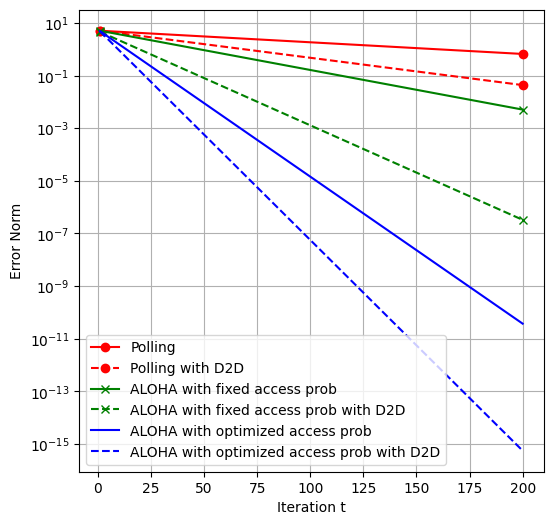

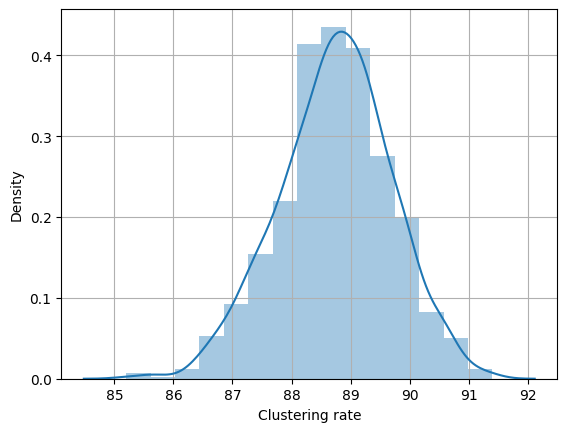

In [11]:
plt.figure(figsize=(6,6))

plt.semilogy(LIST_OF_FL_ITERATIONS_PER_ROUND, error_norm_1_list, 
             color='red',
             linestyle='-',
             linewidth=1.5,
             marker='o',
             label='Polling')
plt.semilogy(LIST_OF_FL_ITERATIONS_PER_ROUND, error_norm_1_d2d_list, 
             color='red', 
             linestyle='--', 
             linewidth=1.5,
             marker='o',
             label='Polling with D2D')


plt.semilogy(LIST_OF_FL_ITERATIONS_PER_ROUND, error_norm_2_list, 
             color='green',
             linestyle='-',
             linewidth=1.5,
             marker='x',
             label='ALOHA with fixed access prob')
plt.semilogy(LIST_OF_FL_ITERATIONS_PER_ROUND, error_norm_2_d2d_list, 
             color='green',
             linestyle='--',
             linewidth=1.5,
             marker='x',
             label='ALOHA with fixed access prob with D2D')


plt.semilogy(LIST_OF_FL_ITERATIONS_PER_ROUND, error_norm_3_list, 
             color='blue', 
             linestyle='-' , 
             linewidth=1.5,
             # marker='*',
             label='ALOHA with optimized access prob')
plt.semilogy(LIST_OF_FL_ITERATIONS_PER_ROUND, error_norm_3_d2d_list, 
             color='blue', 
             linestyle='--', 
             linewidth=1.5,
             # marker='*',
             label='ALOHA with optimized access prob with D2D')


plt.legend()
plt.xlabel('Iteration t')
plt.ylabel('Error Norm')
# plt.title(f'Number of mobile devices = {MOBILE_DEVICES}.\nClustering rate: {np.mean(FL_clustered_devices_rate_list):.2f} %.')
plt.grid(True)
plt.savefig(f'{folder_name}/ERRORS--{MOBILE_DEVICES}_devices--{clustered_devices_rate_list[-1]:.2f}_clustering_rate.eps', format='eps', bbox_inches='tight')
plt.savefig(f'{folder_name}/ERRORS--{MOBILE_DEVICES}_devices--{clustered_devices_rate_list[-1]:.2f}_clustering_rate.png', format='png', bbox_inches='tight')
plt.show()

################################################################################################################################
sns.distplot(FL_clustered_devices_rate_list, bins=15)
plt.xlabel('Clustering rate')
# plt.title(f'Number of mobile devices = {MOBILE_DEVICES}.\nClustering rate mean: {clustered_devices_rate_list[-1]:.2f} %.\nClustering rate std: {np.std(FL_clustered_devices_rate_list):.2f}.')
plt.grid(True)
plt.savefig(f'{folder_name}/STD--{MOBILE_DEVICES}_devices--{clustered_devices_rate_list[-1]:.2f}_clustering_rate--{np.std(FL_clustered_devices_rate_list):.2f}_std.eps', format='eps', bbox_inches='tight')
plt.savefig(f'{folder_name}/STD--{MOBILE_DEVICES}_devices--{clustered_devices_rate_list[-1]:.2f}_clustering_rate--{np.std(FL_clustered_devices_rate_list):.2f}_std.png', format='png', bbox_inches='tight')
plt.show()


## Complementary plottings

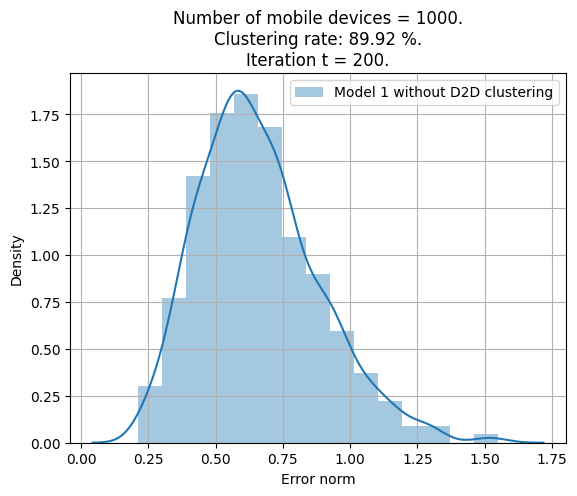

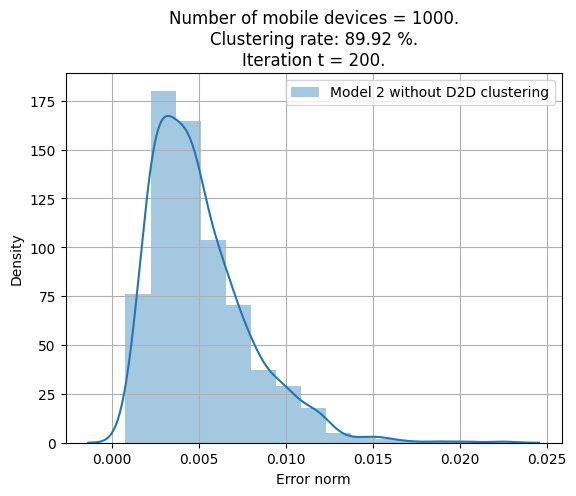

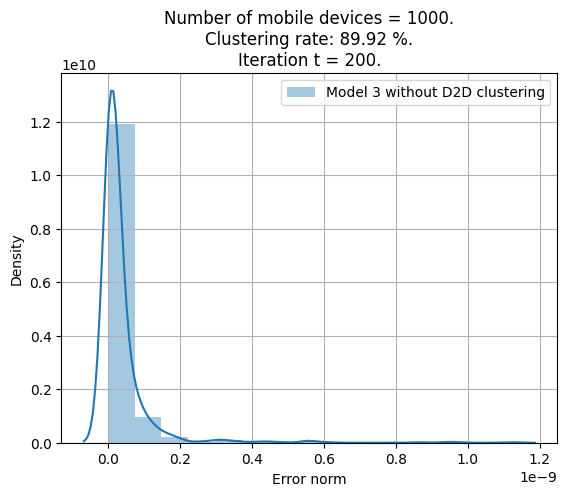

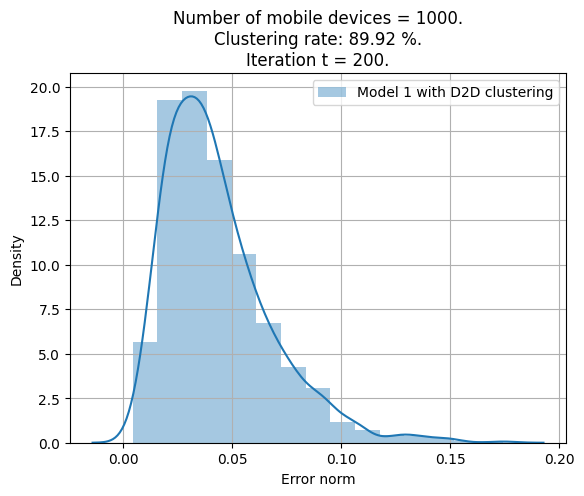

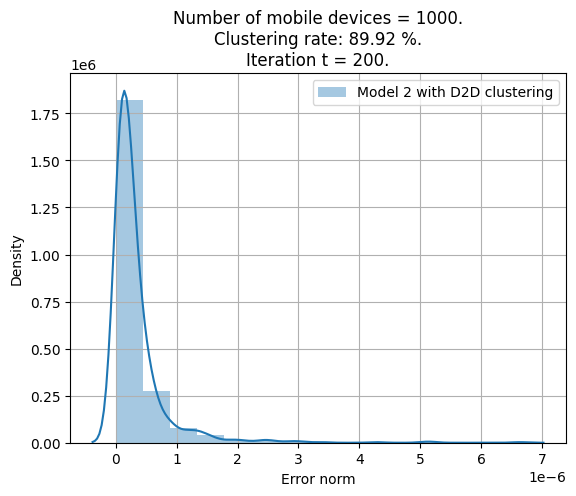

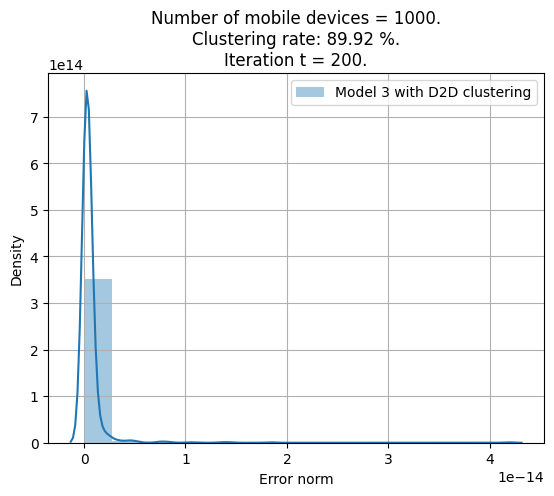

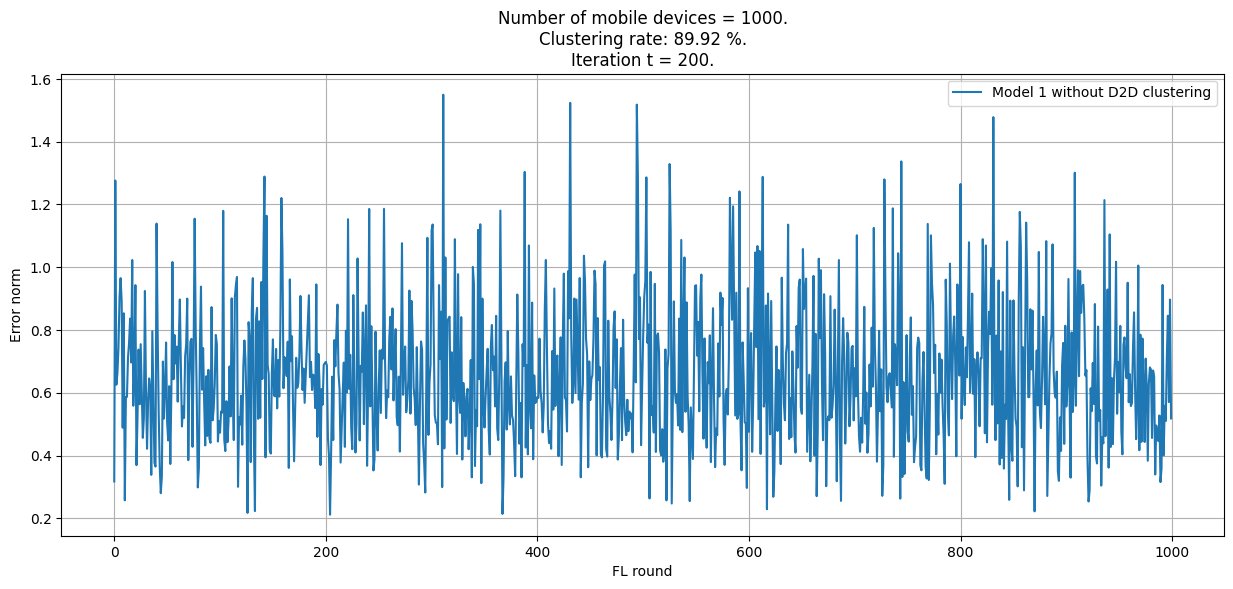

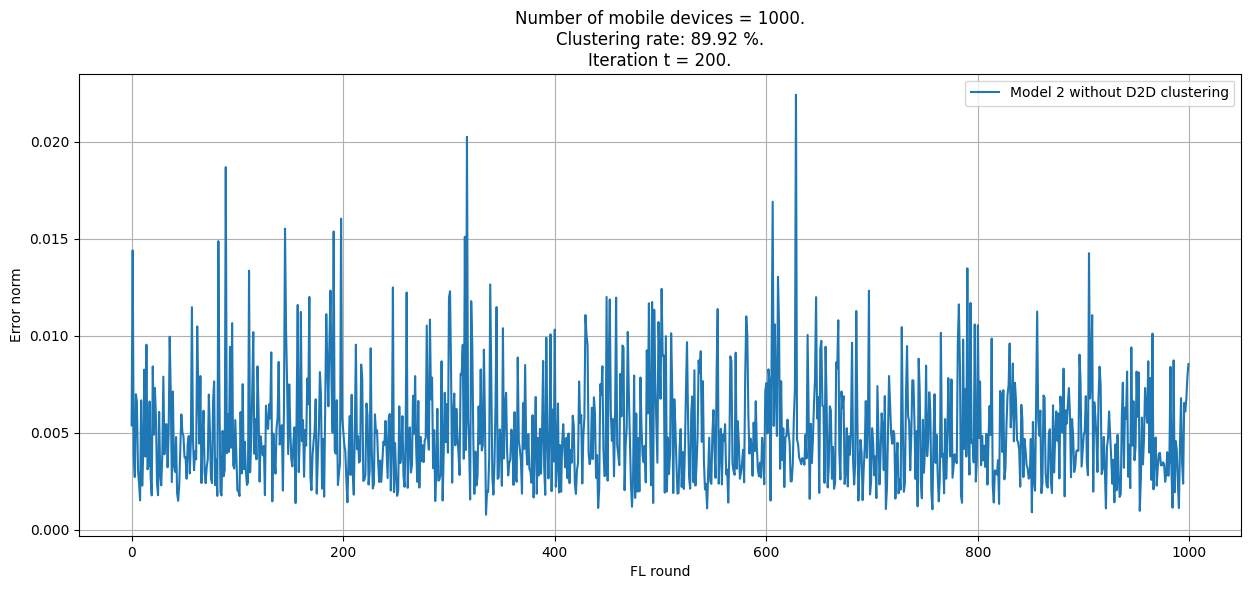

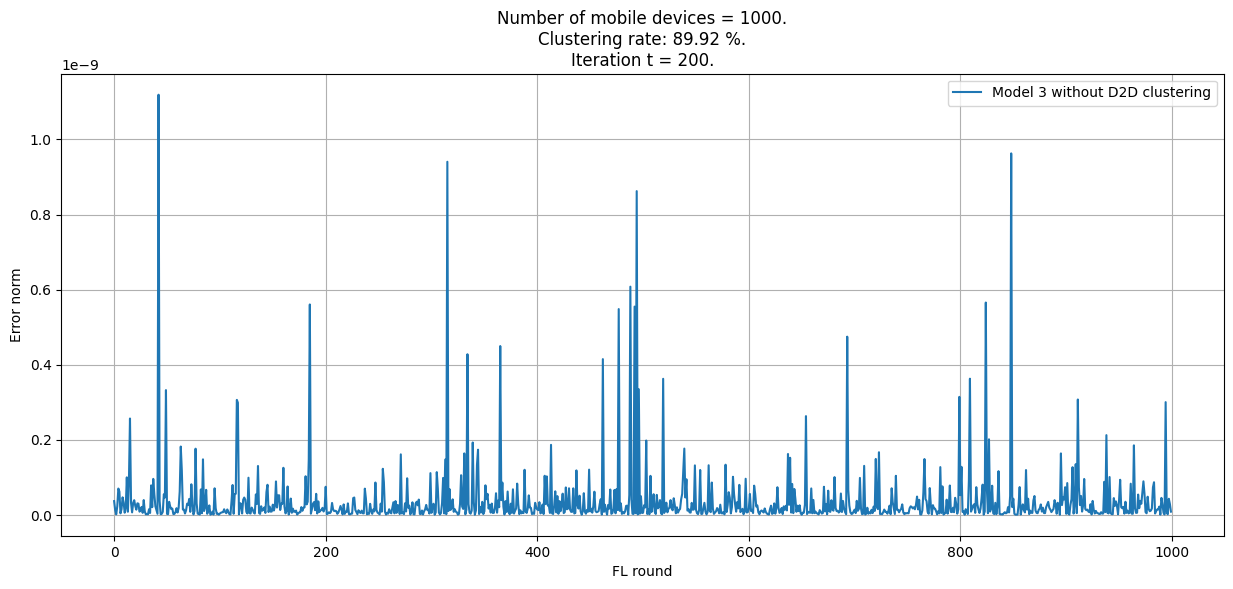

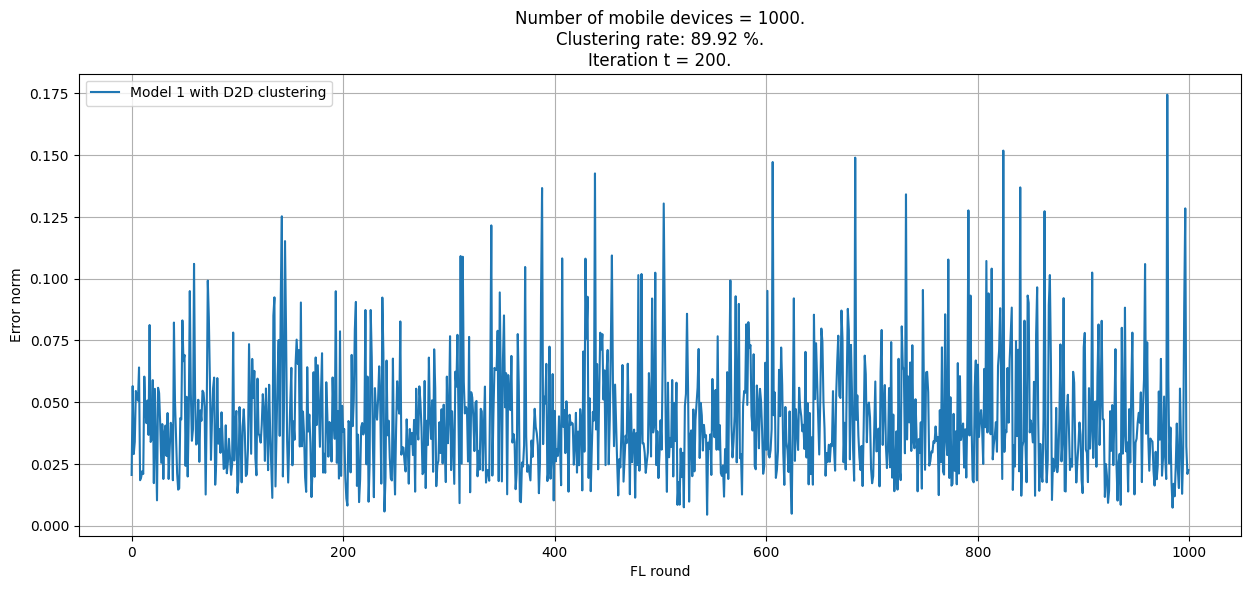

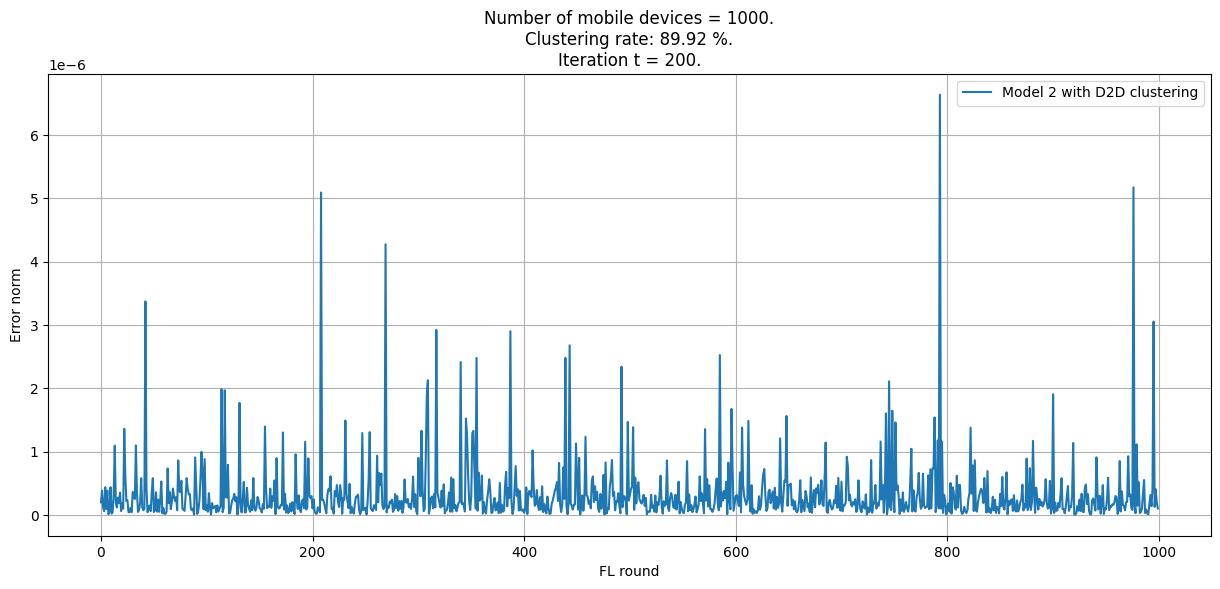

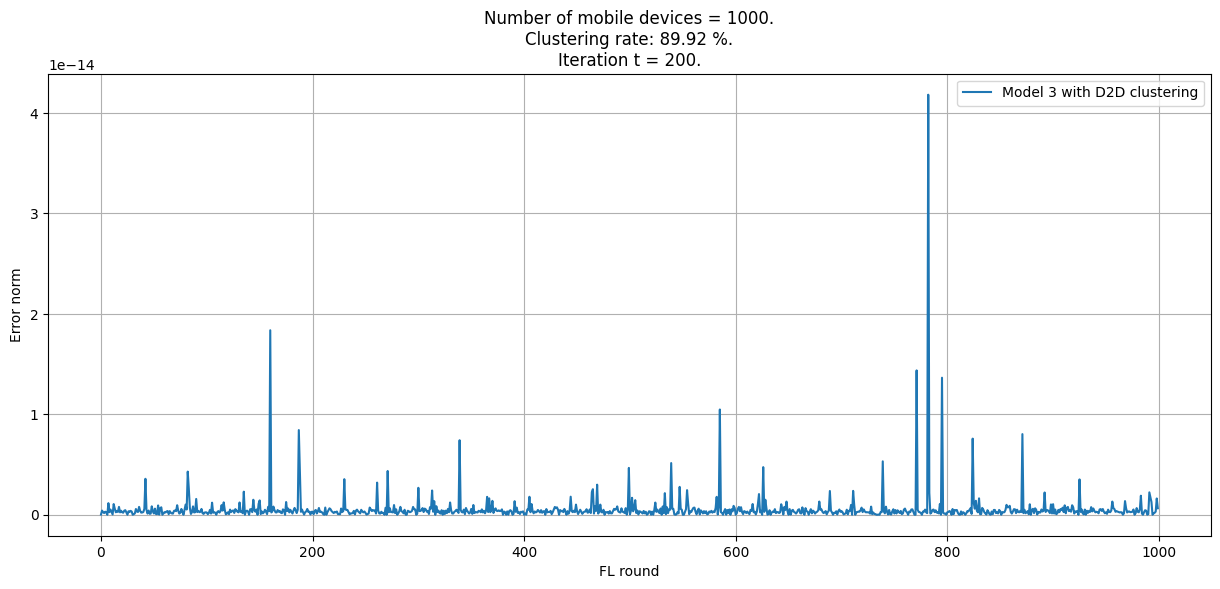

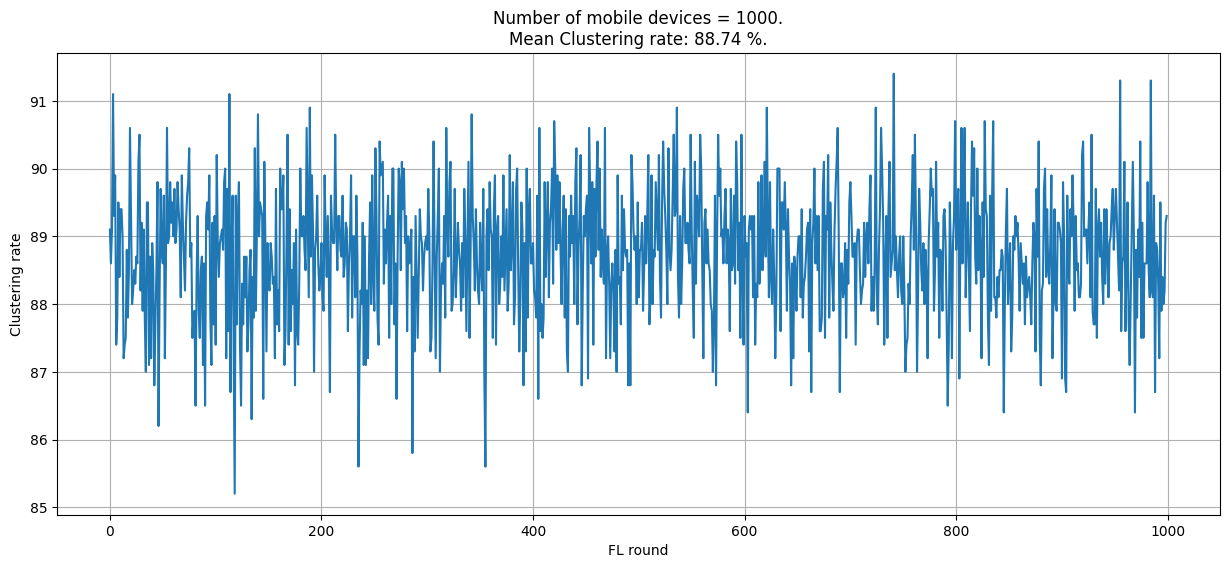

In [12]:
sns.distplot(min_errors_of_the_FL_round_model_1_list, bins=15, label='Model 1 without D2D clustering')
plt.legend()
plt.xlabel('Error norm')
plt.title(f'Number of mobile devices = {MOBILE_DEVICES}.\nClustering rate: {np.mean(clustered_devices_rate_list):.2f} %.\nIteration t = {LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}.')
plt.grid(True)
plt.show()

sns.distplot(min_errors_of_the_FL_round_model_2_list, bins=15, label='Model 2 without D2D clustering')
plt.legend()
plt.xlabel('Error norm')
plt.title(f'Number of mobile devices = {MOBILE_DEVICES}.\nClustering rate: {np.mean(clustered_devices_rate_list):.2f} %.\nIteration t = {LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}.')
plt.grid(True)
plt.show()

sns.distplot(min_errors_of_the_FL_round_model_3_list, bins=15, label='Model 3 without D2D clustering')
plt.legend()
plt.xlabel('Error norm')
plt.title(f'Number of mobile devices = {MOBILE_DEVICES}.\nClustering rate: {np.mean(clustered_devices_rate_list):.2f} %.\nIteration t = {LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}.')
plt.grid(True)
plt.show()

################################################################################################################################
sns.distplot(min_errors_of_the_FL_round_model_1_d2d_list, bins=15, label='Model 1 with D2D clustering')
plt.legend()
plt.xlabel('Error norm')
plt.title(f'Number of mobile devices = {MOBILE_DEVICES}.\nClustering rate: {np.mean(clustered_devices_rate_list):.2f} %.\nIteration t = {LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}.')
plt.grid(True)
plt.show()

sns.distplot(min_errors_of_the_FL_round_model_2_d2d_list, bins=15, label='Model 2 with D2D clustering')
plt.legend()
plt.xlabel('Error norm')
plt.title(f'Number of mobile devices = {MOBILE_DEVICES}.\nClustering rate: {np.mean(clustered_devices_rate_list):.2f} %.\nIteration t = {LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}.')
plt.grid(True)
plt.show()

sns.distplot(min_errors_of_the_FL_round_model_3_d2d_list, bins=15, label='Model 3 with D2D clustering')
plt.legend()
plt.xlabel('Error norm')
plt.title(f'Number of mobile devices = {MOBILE_DEVICES}.\nClustering rate: {np.mean(clustered_devices_rate_list):.2f} %.\nIteration t = {LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}.')
plt.grid(True)
plt.show()

################################################################################################################################
plt.figure(figsize=(15,6))
plt.plot(min_errors_of_the_FL_round_model_1_list, label="Model 1 without D2D clustering")
plt.legend()
plt.xlabel('FL round')
plt.ylabel('Error norm')
plt.title(f'Number of mobile devices = {MOBILE_DEVICES}.\nClustering rate: {np.mean(clustered_devices_rate_list):.2f} %.\nIteration t = {LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}.')
plt.grid(True)
plt.show()

plt.figure(figsize=(15,6))
plt.plot(min_errors_of_the_FL_round_model_2_list, label="Model 2 without D2D clustering")
plt.legend()
plt.xlabel('FL round')
plt.ylabel('Error norm')
plt.title(f'Number of mobile devices = {MOBILE_DEVICES}.\nClustering rate: {np.mean(clustered_devices_rate_list):.2f} %.\nIteration t = {LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}.')
plt.grid(True)
plt.show()

plt.figure(figsize=(15,6))
plt.plot(min_errors_of_the_FL_round_model_3_list, label="Model 3 without D2D clustering")
plt.legend()
plt.xlabel('FL round')
plt.ylabel('Error norm')
plt.title(f'Number of mobile devices = {MOBILE_DEVICES}.\nClustering rate: {np.mean(clustered_devices_rate_list):.2f} %.\nIteration t = {LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}.')
plt.grid(True)
plt.show()

################################################################################################################################
plt.figure(figsize=(15,6))
plt.plot(min_errors_of_the_FL_round_model_1_d2d_list, label="Model 1 with D2D clustering")
plt.legend()
plt.xlabel('FL round')
plt.ylabel('Error norm')
plt.title(f'Number of mobile devices = {MOBILE_DEVICES}.\nClustering rate: {np.mean(clustered_devices_rate_list):.2f} %.\nIteration t = {LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}.')
plt.grid(True)
plt.show()

plt.figure(figsize=(15,6))
plt.plot(min_errors_of_the_FL_round_model_2_d2d_list, label="Model 2 with D2D clustering")
plt.legend()
plt.xlabel('FL round')
plt.ylabel('Error norm')
plt.title(f'Number of mobile devices = {MOBILE_DEVICES}.\nClustering rate: {np.mean(clustered_devices_rate_list):.2f} %.\nIteration t = {LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}.')
plt.grid(True)
plt.show()

plt.figure(figsize=(15,6))
plt.plot(min_errors_of_the_FL_round_model_3_d2d_list, label="Model 3 with D2D clustering")
plt.legend()
plt.xlabel('FL round')
plt.ylabel('Error norm')
plt.title(f'Number of mobile devices = {MOBILE_DEVICES}.\nClustering rate: {np.mean(clustered_devices_rate_list):.2f} %.\nIteration t = {LIST_OF_FL_ITERATIONS_PER_ROUND[-1]}.')
plt.grid(True)
plt.show()

################################################################################################################################
plt.figure(figsize=(15,6))
plt.plot(FL_clustered_devices_rate_list)
plt.xlabel('FL round')
plt.ylabel('Clustering rate')
plt.title(f'Number of mobile devices = {MOBILE_DEVICES}.\nMean Clustering rate: {np.mean(FL_clustered_devices_rate_list):.2f} %.')
plt.grid(True)
plt.show()

# End